In [10]:

from data_pipeline.ukb_data_extractor import UkbDataExtractor
import data_pipeline.data_processing_utils as dpu
from data_pipeline.odir_5k_data_extractor import ODIR5KDataExtractor
from data_pipeline.rfmid_data_extractor import RFMiDDataExtractor
from data_pipeline.rfmid2_data_extractor import RFMiD2DataExtractor
from data_pipeline.ukb_data_extractor import UkbDataExtractor
from data_pipeline.rips_data_extractor import RIPSDataExtractor
from data_pipeline.ses_data_extractor import SESDataExtractor
from data_pipeline.one_thousand_images_data_extractor import OneThousandImagesDataExtractor
from data_pipeline.data_processing_utils import standardize_labels
import data_pipeline.data_processing_utils as dpu

import numpy as np
from uuid import uuid4
import json
from datetime import datetime
import os
import pandas as pd


In [11]:

dataset_name = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
dataset_path = f'datasets/{dataset_name}'

In [12]:
labels_to_encode = np.array(["Age-related Macular Degeneration", "Best Disease", "Bietti crystalline dystrophy",
                              "cataract", "Cone Dystrophy or Cone-rod Dystrophy", "Diabetic Retinopathy",
                              "glaucoma", "Maculopathy", "Myopia", "Normal", "Retinitis Pigmentosa", "Stargardt Disease", "Macular dystrophy", "Pseudoxanthoma elasticum",
                                "Retinal Dystrophy", "Optic atrophy", "Usher-Syndrom", "Drusen",
                                "Leber Hereditary Optic Neuropathy", "Choroideremia", "Sorsby Fundus Dystrophy"])

In [13]:
labels_to_encode[10]

'Retinitis Pigmentosa'

In [14]:
ukb_database_path = 'databases/ird_dataset/IRD-Dataset-Complete-03-anonymized.xlsx'
ukb_data_path ='databases/ird_dataset/export_heyex_original_dataset_03/DICOM'
ukb_extractor = UkbDataExtractor(database_path=ukb_data_path, label_path=ukb_database_path)

odir5k_data_extractor = ODIR5KDataExtractor(database_path='databases/ODIR-5K/full_df.csv', database_test_images_path='databases/ODIR-5K/Testing Images',
                                                database_train_images_path='databases/ODIR-5K/Training Images')

rfmid_train_data_extractor = RFMiDDataExtractor(database_path='databases/RFMiD/Training_Set/RFMiD_Training_Labels.csv',
                                            data_path='databases/RFMiD/Training_Set/Training', file_format='png')

rfmid_validation_datae_xtractor = RFMiDDataExtractor(database_path='databases/RFMiD/Evaluation_Set/RFMiD_Validation_Labels.csv',
                                            data_path='databases/RFMiD/Evaluation_Set/Validation', file_format='png')

rfmid_test_data_extractor = RFMiDDataExtractor(database_path='databases/RFMiD/Test_Set/RFMiD_Testing_Labels.csv',
                                                data_path='databases/RFMiD/Test_Set/Test', file_format='png')

rfmid2_train_data_extractor = RFMiD2DataExtractor(database_path='databases/RFMiD2_0/Training_set/RFMiD_2_Training_labels.csv',
                                                    data_path='databases/RFMiD2_0/Training_set')
rfmid2_validation_data_extractor = RFMiD2DataExtractor(database_path='databases/RFMiD2_0/Validation_set/RFMiD_2_Validation_labels.csv',
                                                            data_path='databases/RFMiD2_0/Validation_set')

rfmid2_test_data_extractor = RFMiD2DataExtractor(database_path='databases/RFMiD2_0/Test_set/RFMiD_2_Testing_labels.csv',
                                                        data_path='databases/RFMiD2_0/Test_set')


one_thousand_images_data_extractor = OneThousandImagesDataExtractor(database_path='databases/1000images/')

rips_data_extractor = RIPSDataExtractor(database_path='databases/RIPS/Original')

ses_data_extractor = SESDataExtractor(database_path='databases/SES/')


In [15]:
#create the data extraction list
default_data_extractors = [odir5k_data_extractor, rfmid_train_data_extractor, rfmid_validation_datae_xtractor, rfmid_test_data_extractor,
                    rfmid2_train_data_extractor, rfmid2_validation_data_extractor, rfmid2_test_data_extractor,
                    one_thousand_images_data_extractor, rips_data_extractor, ses_data_extractor]

dicom_data_extractors = [ukb_extractor]

data_extractors = default_data_extractors + dicom_data_extractors


In [16]:
#extract the data
for data_extractor in data_extractors:
    data_extractor.extract()

#standardize the data
#get the labels of the data
datasets_labels = []
for data_extractor in data_extractors:
    datasets_labels.append(data_extractor.get_labels())
#flatten
labels = []
for dataset_labels in datasets_labels:
    labels.extend(dataset_labels)
#concatenate the labels
labels = np.concatenate(labels)
#drop the None values
labels = labels[labels != None]

In [17]:
ukb_labels = ukb_extractor.get_labels()
unique_labels, counts = np.unique(ukb_labels, return_counts=True)
print(unique_labels)
print(counts)

['Achromatopsie' 'Albinismus' 'BBS' 'CSNB' 'Chorioideremie' 'Drusen'
 'Fundus albipunctatus' 'LHON' 'Makuladystrophie' 'Morbus Best'
 'Morbus Stargardt' 'Netzhautdystrophie' 'Optikusatrophie' 'PXE'
 'Retinitis Pigmentosa' 'Retinitis pigmentosa' 'Retinochisis'
 'Sorsby Fundus Dystrophie' 'Usher-Syndrom']
[  2   3  22  11  34  38  16  49 352  42 219 239  45 136   2 809  16  36
  40]


In [18]:
not_summarize_set = set(RFMiD2DataExtractor.abbreviation_map.values())
not_summarize_set.update('Optic atrophy', 'atrophy')
ukb_label_mapping_dict = {'Morbus Best': 'Best Disease', 'Morbus Stargardt': 'Stargardt Disease', 'Retinitis pigmentosa': 'Retinitis Pigmentosa',
                           'Morbus Stargardt ': 'Stargardt Disease', 'Optikusatrophie': 'Optic atrophy',
                             'LHON': 'Leber Hereditary Optic Neuropathy', "Netzhautdystrophie": "Retinal Dystrophy", 
                             "Makuladystrophie": "Macular dystrophy", "Makuladystrophie ": "Macular dystrophy",
                               "Drusen": "Drusen", "Usher-Syndrom": "Usher-Syndrom",
                             'PXE' : "Pseudoxanthoma elasticum", "Sorsby Fundus Dystrophie": "Sorsby Fundus Dystrophy",
                             "Chorioideremie" :"Choroideremia"}
label_standertizer = standardize_labels(labels = labels, not_summarize_set=not_summarize_set)
necessary_corrections = {
    'optic nerve atrophy': 'Optic atrophy',
    'BRVO': 'Branch Retinal Vein Occlusion',
    'CRVO': 'Central Retinal Vein Occlusion',
    'CSCR': 'Central Serous Chorioretinopathy',
    'DR1': 'Diabetic Retinopathy',
    'DR2': 'Diabetic Retinopathy',
    'DR3': 'Diabetic Retinopathy',
    'ERM': 'Epiretinal Membrane',
    'MH': 'Macular Hole',
    'RAO': 'Retinal Artery Occlusion',
    'normal fundus': 'Normal',
}
label_standertizer.update(ukb_label_mapping_dict)
label_standertizer.update(necessary_corrections)
#remove all the key value pairs that have atrpohy in them
label_standertizer = {k: v for k, v in label_standertizer.items() if not 'atrophy' == v}
#drop all the colomba values
label_standertizer = {k: v for k, v in label_standertizer.items() if not 'Coloboma' == v}

In [19]:
print(label_standertizer)

{'drusen': 'Drusen', 'Drusens': 'Drusen', 'myopia retinopathy': 'Myopia', 'Pathological myopia': 'Myopia', 'pathological myopia': 'Myopia', 'normal fundus': 'Normal', 'optic nerve atrophy': 'Optic atrophy', 'Retinitis pigmentosa': 'Retinitis Pigmentosa', 'retinitis pigmentosa': 'Retinitis Pigmentosa', 'Laser Spots': 'laser spot', 'maculopathy': 'Maculopathy', 'myopic maculopathy': 'Maculopathy', 'Optic Disc Pit Maculopathy': 'Maculopathy', 'macular hole': 'Macular Hole', 'optic disc edema': 'Optic Disc Edema', 'Cotton-wool spots': 'Cotton-Wool Spots', 'vessel tortuosity': 'Vessel tortuosity', 'retinal detachment': 'Retinal Detachment', 'tessellated fundus': 'Tessellated fundus', 'epiretinal membrane': 'Epiretinal Membrane', 'macular epiretinal membrane': 'Epiretinal Membrane', 'optic disk epiretinal membrane': 'Epiretinal Membrane', 'epiretinal membrane over the macula': 'Epiretinal Membrane', 'diabetic retinopathy': 'Diabetic Retinopathy', 'proliferative diabetic retinopathy': 'Diabet

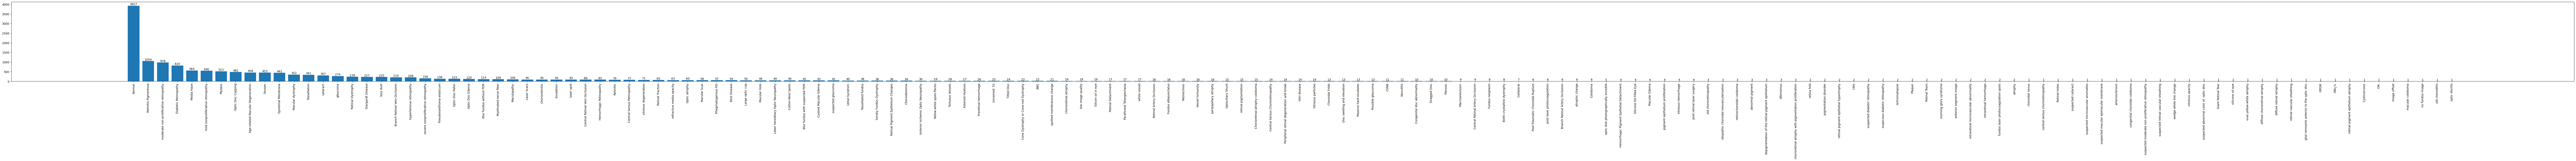

In [20]:
#count the unique labels
import matplotlib.pyplot as plt
#standardize the labels
labels_standardized = np.array([label_standertizer.get(label,label) for label in labels])
unique_labels, counts = np.unique(labels_standardized, return_counts=True)
#plot the labels in a bar chart that scales with the number of labels
plt.figure(figsize=(len(unique_labels), 5))
#sort the labels by the count descending
unique_labels = unique_labels[np.argsort(counts)[::-1]]
counts = counts[np.argsort(counts)[::-1]]
plt.bar(unique_labels, counts)
plt.xticks(rotation=90)
#annotate the bars by the count
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
#sort the bars by the count
plt.show()


In [21]:
#check how many instances usher syndrom has
usher_syndrome_index = np.where(labels_standardized == 'Achromatopsie')[0]
usher_syndrome_labels = labels[usher_syndrome_index]
print(len(usher_syndrome_labels))

2


In [22]:
#print the labels
print(sorted(unique_labels))

['Achromatopsie', 'Age-related Macular Degeneration', 'Albinismus', 'Anterior Ischemic Optic Neuropathy', 'Asteroid Hyalosis', 'BBS', 'Best Disease', 'Bietti crystalline dystrophy', 'Blur fundus with suspected PDR', 'Blur fundus without PDR', 'Branch Retinal Artery Occlusion', 'Branch Retinal Vein Occlusion', 'CNV', 'CSNB', 'Central Retinal Artery Occlusion', 'Central Retinal Vein Occlusion', 'Central Serous Chorioretinopathy', 'Central Serous Retinopathy', 'Chorioretinal atrophy-coloboma', 'Chorioretinitis', 'Choroidal Folds', 'Choroideremia', 'Collateral', 'Coloboma', 'Cone Dystrophy or Cone-rod Dystrophy', 'Congenital disc abnormality', 'Cotton-Wool Spots', 'Cysticercosis', 'Cystoid Macular Edema', 'Diabetic Retinopathy', 'Disc swelling and elevation', 'Dragged Disc', 'Drusen', 'Epiretinal Membrane', 'Exudation', 'Fibrosis', 'Fundus albipunctatus', 'Fundus neoplasm', 'Giant Retinal Tear', 'Hemorrhagic Pigment Epithelial Detachment', 'Hemorrhagic Retinopathy', 'Large optic cup', 'Las

In [23]:
#find all keys that contain a ,
keys_with_comma = [key for key in label_standertizer.keys() if ',' in key]
print(keys_with_comma)

[]


In [24]:
#value count the labels
label_counts = pd.Series(labels).value_counts()
#get the median label count
median_label_count = label_counts.median()
label_instance_limit = int((max(label_counts) - median_label_count) // 4)
#balance the labels
#find the over represented labels
for labels,extractor in zip(datasets_labels, data_extractors):
    #find the over represented labels
    #replace none with empty string
    over_represented_labels_idxs, _, _ = dpu.find_over_represented_samples(file_paths=extractor.get_file_paths(), labels=labels,
                                                                            max_samples_per_class=label_instance_limit)
    #remove the over represented labels
    #conver the indexes to a boolean array
    over_represented_labels_series = np.isin(np.arange(len(labels)), over_represented_labels_idxs)
    extractor.extracted_data = extractor.extracted_data[~over_represented_labels_series]

In [25]:
#split the data stratified by the labels
train_portion = 0.7
val_portion = 0.1
test_portion = 0.2
split_portions = [train_portion, val_portion, test_portion]

In [26]:
ses_labels = ses_data_extractor.get_labels()
unique_ses_labels, ses_counts = np.unique(ses_labels, return_counts=True)
print(unique_ses_labels)
print(ses_counts)

['Best Disease' 'Cone Dystrophy or Cone-rod Dystrophy'
 'Retinitis Pigmentosa' 'Stargardt Disease']
[12 22 81  8]


In [27]:
splits = []
for data_extractor in data_extractors:
    splits.extend(data_extractor.split_extracted_data(split_portions = split_portions, stratify=True))

Dynamic counts: [0, 0, 0]
Empty partition found: 0
Dynamic counts: [2, 0, 0]
Empty partition found: 1
Dynamic counts: [2, 2, 0]
Empty partition found: 2
[2978, 426, 850]
0
0
Dynamic counts: [0, 0, 0]
Empty partition found: 0
Dynamic counts: [30, 0, 0]
Empty partition found: 1
Dynamic counts: [30, 30, 0]
Empty partition found: 2
[60, 30, 30]
0
Dynamic counts: [0, 0, 0]
Empty partition found: 0
[2, 0, 0]
0
Dynamic counts: [0, 0, 0]
Empty partition found: 0
[3, 0, 0]
0
Dynamic counts: [0, 0, 0]
Empty partition found: 0
Dynamic counts: [5, 0, 0]
Empty partition found: 1
Dynamic counts: [5, 4, 0]
Empty partition found: 2
[14, 4, 4]
0
0
0
0
Dynamic counts: [0, 0, 0]
Empty partition found: 0
Dynamic counts: [5, 0, 0]
Empty partition found: 1
Dynamic counts: [5, 2, 0]
Empty partition found: 2
[7, 2, 2]
0
0
Dynamic counts: [0, 0, 0]
Empty partition found: 0
Dynamic counts: [8, 0, 0]
Empty partition found: 1
Dynamic counts: [8, 7, 0]
Empty partition found: 2
[23, 7, 4]
0
0
0
0
0
Dynamic counts: 

In [28]:
lambda_strip = lambda x: x.strip() if isinstance(x, str) else x
label_translation = lambda x: label_standertizer.get(x, x)
for i, split in enumerate(splits):
    #strip trailing and leading whitespaces
    #split.labels = np.vectorize(lambda_strip)(split.labels)
    split.labels = np.vectorize(label_translation)(split.labels)


In [29]:
#get all the labels
all_labels = []
for split in splits:
    all_labels.extend(split.labels)
#create set of all labels
all_labels = np.concatenate(all_labels)
#filter out the None values
all_labels = all_labels[all_labels != None]
all_labels = np.unique(all_labels)

In [30]:
label_encoder = dpu.create_one_hot_encoder(unique_labels=labels_to_encode)

In [31]:
for split in splits:
    split.labels = dpu.encode_multistring_labels(split.labels, label_encoder)

In [32]:
print(len(splits[0].get_labels()))

2978


In [33]:
#find out which datapoints have a full 0 label
for split in splits:
    print(split.data_source_name)
    labels = split.get_labels()
    no_zero_labels = np.sum(labels, axis=1) != 0
    #print len false values
    print('n filtered', len(no_zero_labels) - np.sum(no_zero_labels), 'out of', len(no_zero_labels))
    #throw away the datapoints with no labels
    split.labels = labels[no_zero_labels]
    split.data = split.data[no_zero_labels]
    split.instance_ids = split.instance_ids[no_zero_labels]


ODIR-5K
n filtered 1503 out of 2978
ODIR-5K
n filtered 230 out of 426
ODIR-5K
n filtered 427 out of 850
RFMiD
n filtered 579 out of 1341
RFMiD
n filtered 89 out of 200
RFMiD
n filtered 164 out of 379
RFMiD
n filtered 184 out of 444
RFMiD
n filtered 29 out of 66
RFMiD
n filtered 55 out of 130
RFMiD
n filtered 196 out of 448
RFMiD
n filtered 28 out of 64
RFMiD
n filtered 55 out of 128
RFMiD2
n filtered 175 out of 310
RFMiD2
n filtered 30 out of 50
RFMiD2
n filtered 56 out of 95
RFMiD2
n filtered 58 out of 106
RFMiD2
n filtered 9 out of 15
RFMiD2
n filtered 21 out of 35
RFMiD2
n filtered 62 out of 104
RFMiD2
n filtered 10 out of 16
RFMiD2
n filtered 16 out of 29
1000images
n filtered 479 out of 699
1000images
n filtered 68 out of 100
1000images
n filtered 139 out of 201
RIPS
n filtered 0 out of 60
RIPS
n filtered 0 out of 30
RIPS
n filtered 0 out of 30
SES
n filtered 0 out of 86
SES
n filtered 0 out of 12
SES
n filtered 0 out of 25
UKB
n filtered 45 out of 1425
UKB
n filtered 15 out of 21

In [34]:
len(default_data_extractors[0].get_current_split()[0].get_labels())

1475

In [35]:
ukb_unique_labels = ukb_extractor.get_labels()
ukb_unique_labels, counts = np.unique(ukb_unique_labels, return_counts=True)
print(ukb_unique_labels)
print(counts)

['Achromatopsie' 'Albinismus' 'BBS' 'CSNB' 'Chorioideremie' 'Drusen'
 'Fundus albipunctatus' 'LHON' 'Makuladystrophie' 'Morbus Best'
 'Morbus Stargardt' 'Netzhautdystrophie' 'Optikusatrophie' 'PXE'
 'Retinitis Pigmentosa' 'Retinitis pigmentosa' 'Retinochisis'
 'Sorsby Fundus Dystrophie' 'Usher-Syndrom']
[  2   3  22  11  34  38  16  49 352  42 219 239  45 136   2 736  16  36
  40]


In [36]:
#reshape the splits list so that always 3 splits are in a row
buffer = []
for i in range(0, len(splits), 3):
    inner_list = splits[i:i + 3]
    buffer.append(inner_list)
splits = buffer

In [37]:
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [38]:
from datetime import datetime
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
dataset_path = f'datasets/{time}'
train_datas_save_path = f'{dataset_path}/train'
val_datas_save_path = f'{dataset_path}/val'
test_datas_save_path = f'{dataset_path}/test'
save_path_list = [train_datas_save_path, val_datas_save_path, test_datas_save_path]
os.makedirs(train_datas_save_path, exist_ok=True)
os.makedirs(val_datas_save_path, exist_ok=True)
os.makedirs(test_datas_save_path, exist_ok=True)
#crearte a dataset configuration
dataset_config = {'labels_to_encode': labels_to_encode.tolist(), 'label_standertizer': label_standertizer}
with open(f'{dataset_path}/dataset_config.json', 'w') as f:
    json.dump(dataset_config, f)
for split in splits:
    for package, path in zip(split, save_path_list):
        total_path = f'{path}/{package.data_source_name}.json'
        #check if the path already exists
        if os.path.exists(total_path):
            #if it exists, load the file and append the data
            with open(total_path, 'r') as f:
                data = json.load(f)
                data['data'].extend(package.data.tolist())
                data['labels'].extend(package.labels.tolist())
                data['instance_ids'].extend(package.instance_ids.tolist())
            #save the file
            with open(total_path, 'w') as f:
                json.dump(data, f)
        else:
            package.save(f'{total_path}')
    


In [39]:
#get  the validation package
val_package_ukb = splits[-1][0]

#get all the labels from the validation package
val_labels = val_package_ukb.get_labels()
#find where the labels that match the label to look for
label_to_look_for = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
idxs = np.all(val_labels == label_to_look_for, axis=1)
print(np.sum(idxs))
#finde the instance ids
instance_ids = val_package_ukb.instance_ids
#find the instance ids
instance_ids_unique = instance_ids[idxs]
#get the unique ids
unique_ids = np.unique(instance_ids_unique)
print(unique_ids)

26
['0042' '0918' '0927' '0928']


In [40]:
ukb_database_path = 'databases/ird_dataset/IRD-Dataset-Complete-03-anonymized.xlsx'
ukb_data_path ='databases/ird_dataset/export_heyex_original_dataset_03/DICOM'
ukb_extractor = UkbDataExtractor(database_path=ukb_data_path, label_path=ukb_database_path)
ukb_extractor.extract()

array([['0001',
        'databases/ird_dataset/export_heyex_original_dataset_03/DICOM/0001/100062/506240/9020098/00000000',
        'Morbus Stargardt'],
       ['0001',
        'databases/ird_dataset/export_heyex_original_dataset_03/DICOM/0001/100062/506240/9020099/00000001',
        'Morbus Stargardt'],
       ['0002',
        'databases/ird_dataset/export_heyex_original_dataset_03/DICOM/0002/94654/472214/8601390/00000000',
        'Morbus Stargardt'],
       ...,
       ['0998',
        'databases/ird_dataset/export_heyex_original_dataset_03/DICOM/0998/98368/495330/8888520/00000001',
        'Optikusatrophie'],
       ['0999',
        'databases/ird_dataset/export_heyex_original_dataset_03/DICOM/0999/97968/492965/8857989/00000000',
        'Optikusatrophie'],
       ['0999',
        'databases/ird_dataset/export_heyex_original_dataset_03/DICOM/0999/97968/492965/8857990/00000001',
        'Optikusatrophie']], dtype='<U97')

In [41]:
print(len(labels_to_encode))
ukb_labels_unique = ukb_extractor.get_labels()
ukb_labels_unique, counts = np.unique(ukb_labels_unique, return_counts=True)
print(len(ukb_labels_unique))

21
19


In [42]:
ukb_extractor.get_labels().flatten().shape

(2111,)

In [43]:
split_portions = [0.7, 0.1, 0.2]
ukb_extractor.split_extracted_data(split_portions = split_portions, stratify=True)

Dynamic counts: [0, 0, 0]
Empty partition found: 0
[2, 0, 0]
0
Dynamic counts: [0, 0, 0]
Empty partition found: 0
[3, 0, 0]
0
Dynamic counts: [0, 0, 0]
Empty partition found: 0
Dynamic counts: [5, 0, 0]
Empty partition found: 1
Dynamic counts: [5, 4, 0]
Empty partition found: 2
[14, 4, 4]
0
0
0
0
Dynamic counts: [0, 0, 0]
Empty partition found: 0
Dynamic counts: [5, 0, 0]
Empty partition found: 1
Dynamic counts: [5, 2, 0]
Empty partition found: 2
[7, 2, 2]
0
0
Dynamic counts: [0, 0, 0]
Empty partition found: 0
Dynamic counts: [8, 0, 0]
Empty partition found: 1
Dynamic counts: [8, 7, 0]
Empty partition found: 2
[23, 7, 4]
0
0
0
0
0
Dynamic counts: [0, 0, 0]
Empty partition found: 0
Dynamic counts: [4, 0, 0]
Empty partition found: 1
Dynamic counts: [4, 4, 0]
Empty partition found: 2
[26, 4, 8]
0
0
Dynamic counts: [0, 0, 0]
Empty partition found: 0
Dynamic counts: [6, 0, 0]
Empty partition found: 1
Dynamic counts: [6, 6, 0]
Empty partition found: 2
[8, 6, 2]
0
0
Dynamic counts: [0, 0, 0]
